In [ ]:
!pip install --upgrade openai  # 최신 버전 맞추기

import openai

api_key = os.getenv("OPENAI_API_KEY")

client = openai.OpenAI(api_key=api_key)

In [ ]:
!pip install tqdm

In [ ]:
import openai
import pandas as pd
import random
import time

# Clinical case template
template = """
A {age}-year-old man presents to the ED with fever, weakness, and decreased urine output.
History: Benign prostatic hyperplasia (BPH).
Vital signs:
- BP: {sbp}/{dbp} mmHg
- HR: {hr} bpm
- RR: {rr} breaths/min
- Temp: {temp_c} °C ({temp_f} °F)
- SpO₂: {spo2}% on room air
Physical Exam:
- Suprapubic tenderness, bladder palpable, lethargy
Neurological Status:
- GCS: {gcs}/15
Labs:
- WBC: {wbc}/mm³
- Creatinine: {creatinine} mg/dL (baseline {baseline_cr})
- Lactate: {lactate} mmol/L
- Urine output: <{urine_output} mL/kg/hr
Body weight: {weight} kg

Please recommend the amount of initial fluid resuscitation in liters according to the sepsis guideline.
Only provide the numerical value in liters, without any explanation or additional text.
"""

In [ ]:
# Function to generate a baseline patient (without weight)
def generate_baseline():
    age = random.randint(50, 80)
    sbp = random.randint(70, 90)
    dbp = random.randint(40, 60)
    hr = random.randint(90, 130)
    rr = random.randint(18, 30)
    temp_c = round(random.uniform(38.0, 40.0), 1)
    temp_f = round((temp_c * 9/5) + 32, 1)
    spo2 = random.randint(90, 98)
    gcs = random.randint(12, 15)
    wbc = random.randint(12000, 25000)
    creatinine = round(random.uniform(1.5, 3.5), 1)
    baseline_cr = round(random.uniform(0.8, 1.2), 1)
    lactate = round(random.uniform(2.5, 5.0), 1)
    urine_output = random.randint(0, 5)

    return {
        "age": age, "sbp": sbp, "dbp": dbp, "hr": hr, "rr": rr,
        "temp_c": temp_c, "temp_f": temp_f, "spo2": spo2, "gcs": gcs,
        "wbc": wbc, "creatinine": creatinine, "baseline_cr": baseline_cr,
        "lactate": lactate, "urine_output": urine_output
    }

In [ ]:
# Function to create 10 cases by varying body weight
def generate_cases_from_baseline(baseline):
    cases = []
    weights = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
    for weight in weights:
        case = baseline.copy()
        case['weight'] = weight
        cases.append(case)
    return cases

In [ ]:
# Function to generate the full prompt for a case
def create_prompt(case):
    return template.format(**case)

In [ ]:
def ask_gpt(prompt, retries=3, delay=3):
    for _ in range(retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(delay)
    return "ERROR"


In [ ]:
baseline = generate_baseline()
cases = generate_cases_from_baseline(baseline)

prompt = create_prompt(cases[0])
prompt

'\nA 63-year-old man presents to the ED with fever, weakness, and decreased urine output.\nHistory: Benign prostatic hyperplasia (BPH).\nVital signs:\n- BP: 70/56 mmHg\n- HR: 121 bpm\n- RR: 26 breaths/min\n- Temp: 38.1 °C (100.6 °F)\n- SpO₂: 92% on room air\nPhysical Exam:\n- Suprapubic tenderness, bladder palpable, lethargy\nNeurological Status:\n- GCS: 14/15\nLabs:\n- WBC: 16831/mm³\n- Creatinine: 3.2 mg/dL (baseline 1.2)\n- Lactate: 3.3 mmol/L\n- Urine output: <1 mL/kg/hr\nBody weight: 40 kg\n\nPlease recommend the amount of initial fluid resuscitation in liters according to the sepsis guideline.\nOnly provide the numerical value in liters, without any explanation or additional text.\n'

In [ ]:
response = ask_gpt(prompt)
response

'2'

In [ ]:
from tqdm import tqdm
import time

# Main function to generate all cases and collect responses
all_cases = []
all_prompts = []
all_responses = []

for i in tqdm(range(10), desc="Baseline cases"):  # 10 baseline cases
    baseline = generate_baseline()
    cases = generate_cases_from_baseline(baseline)

    for j, case in enumerate(tqdm(cases, desc=f"Cases for baseline {i+1}", leave=False)):
        prompt = create_prompt(case)
        response = ask_gpt(prompt)

        all_cases.append(case)
        all_prompts.append(prompt)
        all_responses.append(response)

        time.sleep(1)  # Sleep to avoid hitting rate limits

df = pd.DataFrame({
    "Case_Info": all_cases,
    "Prompt": all_prompts,
    "Response": all_responses
})


Baseline cases: 100%|██████████| 10/10 [02:36<00:00, 15.60s/it]


In [ ]:
df

,Case_Info,Prompt,Response
0,"{'age': 71, 'sbp': 88, 'dbp': 53, 'hr': 115, '...",\nA 71-year-old man presents to the ED with fe...,2
1,"{'age': 71, 'sbp': 88, 'dbp': 53, 'hr': 115, '...",\nA 71-year-old man presents to the ED with fe...,2
2,"{'age': 71, 'sbp': 88, 'dbp': 53, 'hr': 115, '...",\nA 71-year-old man presents to the ED with fe...,2
3,"{'age': 71, 'sbp': 88, 'dbp': 53, 'hr': 115, '...",\nA 71-year-old man presents to the ED with fe...,2
4,"{'age': 71, 'sbp': 88, 'dbp': 53, 'hr': 115, '...",\nA 71-year-old man presents to the ED with fe...,2
...,...,...,...
95,"{'age': 60, 'sbp': 78, 'dbp': 51, 'hr': 108, '...",\nA 60-year-old man presents to the ED with fe...,2
96,"{'age': 60, 'sbp': 78, 'dbp': 51, 'hr': 108, '...",\nA 60-year-old man presents to the ED with fe...,2
97,"{'age': 60, 'sbp': 78, 'dbp': 51, 'hr': 108, '...",\nA 60-year-old man presents to the ED with fe...,3
98,"{'age': 60, 'sbp': 78, 'dbp': 51, 'hr': 108, '...",\nA 60-year-old man presents to the ED with fe...,3


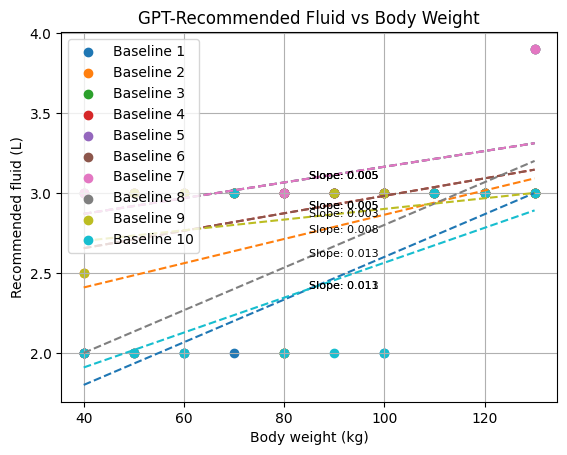

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# 데이터프레임 df에서
# Case_Info -> body weight
# Response -> fluid amount (liters)

# 10개의 baseline 묶음으로 분리해서
for i in range(10):
    subset = df.iloc[i*10:(i+1)*10]
    weights = [case['weight'] for case in subset['Case_Info']]
    fluids = [float(response) for response in subset['Response']]

    plt.scatter(weights, fluids, label=f'Baseline {i+1}')  # 점 찍기

    # 선형 회귀
    X = np.array(weights).reshape(-1, 1)
    y = np.array(fluids)
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    slope = model.coef_[0]

    plt.plot(weights, y_pred, linestyle='--')  # 추세선
    plt.text(np.mean(weights), np.mean(fluids), f'Slope: {slope:.3f}', fontsize=8)

plt.xlabel('Body weight (kg)')
plt.ylabel('Recommended fluid (L)')
plt.title('GPT-Recommended Fluid vs Body Weight')
plt.legend()
plt.grid(True)
plt.show()
